# Data Cleaning of the Ames Housing Dataset

## 1. Missing Values
## 2. Outliers
## 3. Feature Engineering

### Data from:
http://jse.amstat.org/v19n3/decock/AmesHousing.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import re
from scipy import stats
from scipy.special import boxcox1p
import pickle as pkl

pd.set_option('display.max_rows', 500);

In [2]:
df = pd.read_csv('AmesHousing.txt', sep='\t')

# Data Cleaning

## 1.1 Handling missing values

In [3]:
# Lets delete the space in the headings to make it easier 
df.columns = df.columns.str.replace(' ', '')
# we wont need the ordrer column
df.drop('Order', axis=1, inplace=True)

In [4]:
# The dataset has lots of NA which were automatically transformed into nan by pandas BUT some actually describe the absence of an element 
# --> FirePlaceQ: NA = No Fireplace

cols_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

df[cols_NA] = df[cols_NA].fillna(value='NA')

df.isnull().sum().sort_values(ascending=False)[:16]

LotFrontage     490
GarageYrBlt     159
GarageQual      159
BsmtExposure     83
MasVnrArea       23
MasVnrType       23
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BedroomAbvGr      0
dtype: int64

In [5]:
# LotFrontage
# https://www.burlington.ca/en/services-for-you/resources/Initiative%20Projects/Shoreacres/FINAL_Shoreacres_Worksheets.pdf
# It seems that I could calculate it with the Lot Area feature and Lot config, lets try that.
df_lots = df.loc[:, [col for col in df if col.startswith('Lot')]]

# lets create a dict to retrieve val and replace the missing value with the mean of lot shape and config grouped
lots_dict = df_lots.groupby(['LotShape', 'LotConfig']).agg('mean').to_dict()

In [6]:
# create dataset with only nan
df_lots_na = df_lots.loc[(df['LotFrontage'].isnull())]

In [7]:
lots_dict['LotFrontage']['IR1', 'Corner']

93.66129032258064

In [8]:
# create new dict to replace vals
new_vals = dict()

for idx, row, in df_lots_na.iterrows():
    #replace with dict
    new_vals[idx] = lots_dict['LotFrontage'][row[2], row[3]]

# map the new values into the df column
s = df.LotFrontage
s = s.map(new_vals).fillna(new_vals)
s = s.fillna(df.LotFrontage)
df['LotFrontage'] = s

df['LotFrontage'].isnull().sum() # 0!

del lots_dict
del new_vals
del df_lots_na
del df_lots

In [9]:
df.isnull().sum().sort_values(ascending=False)

# GarageYrBlt | GarageQual -- 159 missing values 
# garageQual is supposed to have NA values, lets check that 
df.loc[df['GarageQual'].isnull(), ['GarageQual', 'GarageArea']] # indeed they all have 0 m2 so it just does not exist.
df['GarageQual'].fillna(value='NA', inplace=True)

# for garage year build, I am going to check if its usually constructed with the house, if so replace the missing vals with the year the house was built
df['YearBuilt'].isnull().sum() # 0
count = 0
for idx, row in df[['YearBuilt', 'GarageYrBlt']].iterrows():
    if row[0] == row[1]:
        count +=1
print(f'{count/df.shape[0]*100} have their garage build when the house is build') # 76% --> fair enought to replace!

76.00682593856656 have their garage build when the house is build


In [10]:
# map the new values into the df column
s = df.GarageYrBlt
s = s.map(s).fillna(df.YearBuilt)
df['GarageYrBlt'] = s

df['GarageYrBlt'].isnull().sum() # 0!

0

In [11]:
# BsmtExposure - 83 missing vals 
df_bsmt = df.loc[:, [col for col in df if col.startswith('Bsmt')]]
df_bsmt.loc[df.BsmtExposure.isnull(),:]
# one bas unfinished the other dont have a basement 
df.loc[66,"BsmtExposure"] = "No"
df.BsmtExposure.fillna(value='NA', inplace=True)

In [12]:
# MasVnrType/MasVnrArea - 23 nan
df.MasVnrType.value_counts() # so its not none transformed into nan
df.loc[df['MasVnrType'].isnull(), ['MasVnrType', 'MasVnrArea']]
# Replace by none and 0
df.MasVnrType.fillna(value='NA', inplace=True)
df.MasVnrArea.fillna(value=0, inplace=True)

In [13]:
df.isnull().sum().sort_values(ascending=False)

df.loc[df['BsmtFullBath'].isnull(), ['BsmtFullBath', 'BsmtHalfBath', 'Electrical', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']]

# looked at one by one 
df_bsmt.loc[df['BsmtFullBath'].isnull()]
df.BsmtFinSF1.fillna(value=0, inplace=True)
df.BsmtFullBath.fillna(value=0, inplace=True)
df.BsmtHalfBath.fillna(value=0, inplace=True)
df.BsmtFinSF1.fillna(value=0, inplace=True)
df.BsmtFinSF2.fillna(value=0, inplace=True)
df.BsmtUnfSF.fillna(value=0, inplace=True)
df.TotalBsmtSF.fillna(value=0, inplace=True)

del df_bsmt

In [14]:
# GarageCars - GarageArea - Electrical 
df.loc[df['GarageCars'].isnull(), ['GarageCars', 'GarageArea', 'GarageType', 'GarageFinish', 'GarageQual', 'Electrical']]
df.GarageCars.fillna(value=0, inplace=True)
df.GarageArea.fillna(value=0, inplace=True)

In [15]:
df['Electrical'].value_counts() # replace by most common
df.Electrical.fillna(value='SBrkr', inplace=True)

In [16]:
df.isnull().sum().sum() # 0!

0

# Data Cleaning

## 1.2 Outliers

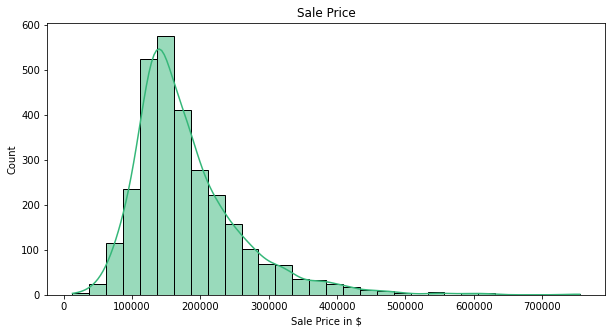

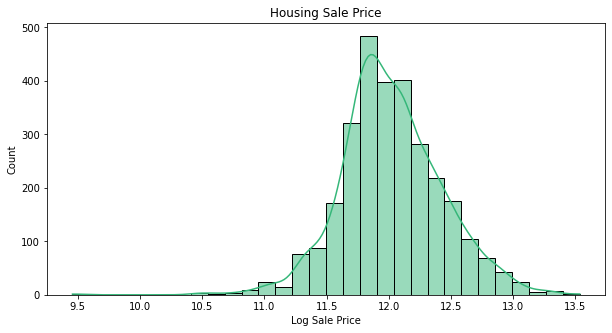

In [17]:
# first lets plot the target 
palette = sns.color_palette('viridis', 5)

fig = plt.subplots(figsize=(10,5))

sns.histplot(df.SalePrice, bins=30, kde=True, color=palette[3])
plt.title('Sale Price')
plt.xlabel('Sale Price in $');

# SalePrice is still very skewed, lets add a log
fig = plt.subplots(figsize=(10,5))

sns.histplot(np.log1p(df.SalePrice), bins=30, kde=True, color=palette[3])
plt.title('Housing Sale Price')
plt.xlabel('Log Sale Price');

df['logSalePrice'] = np.log1p(df['SalePrice'])

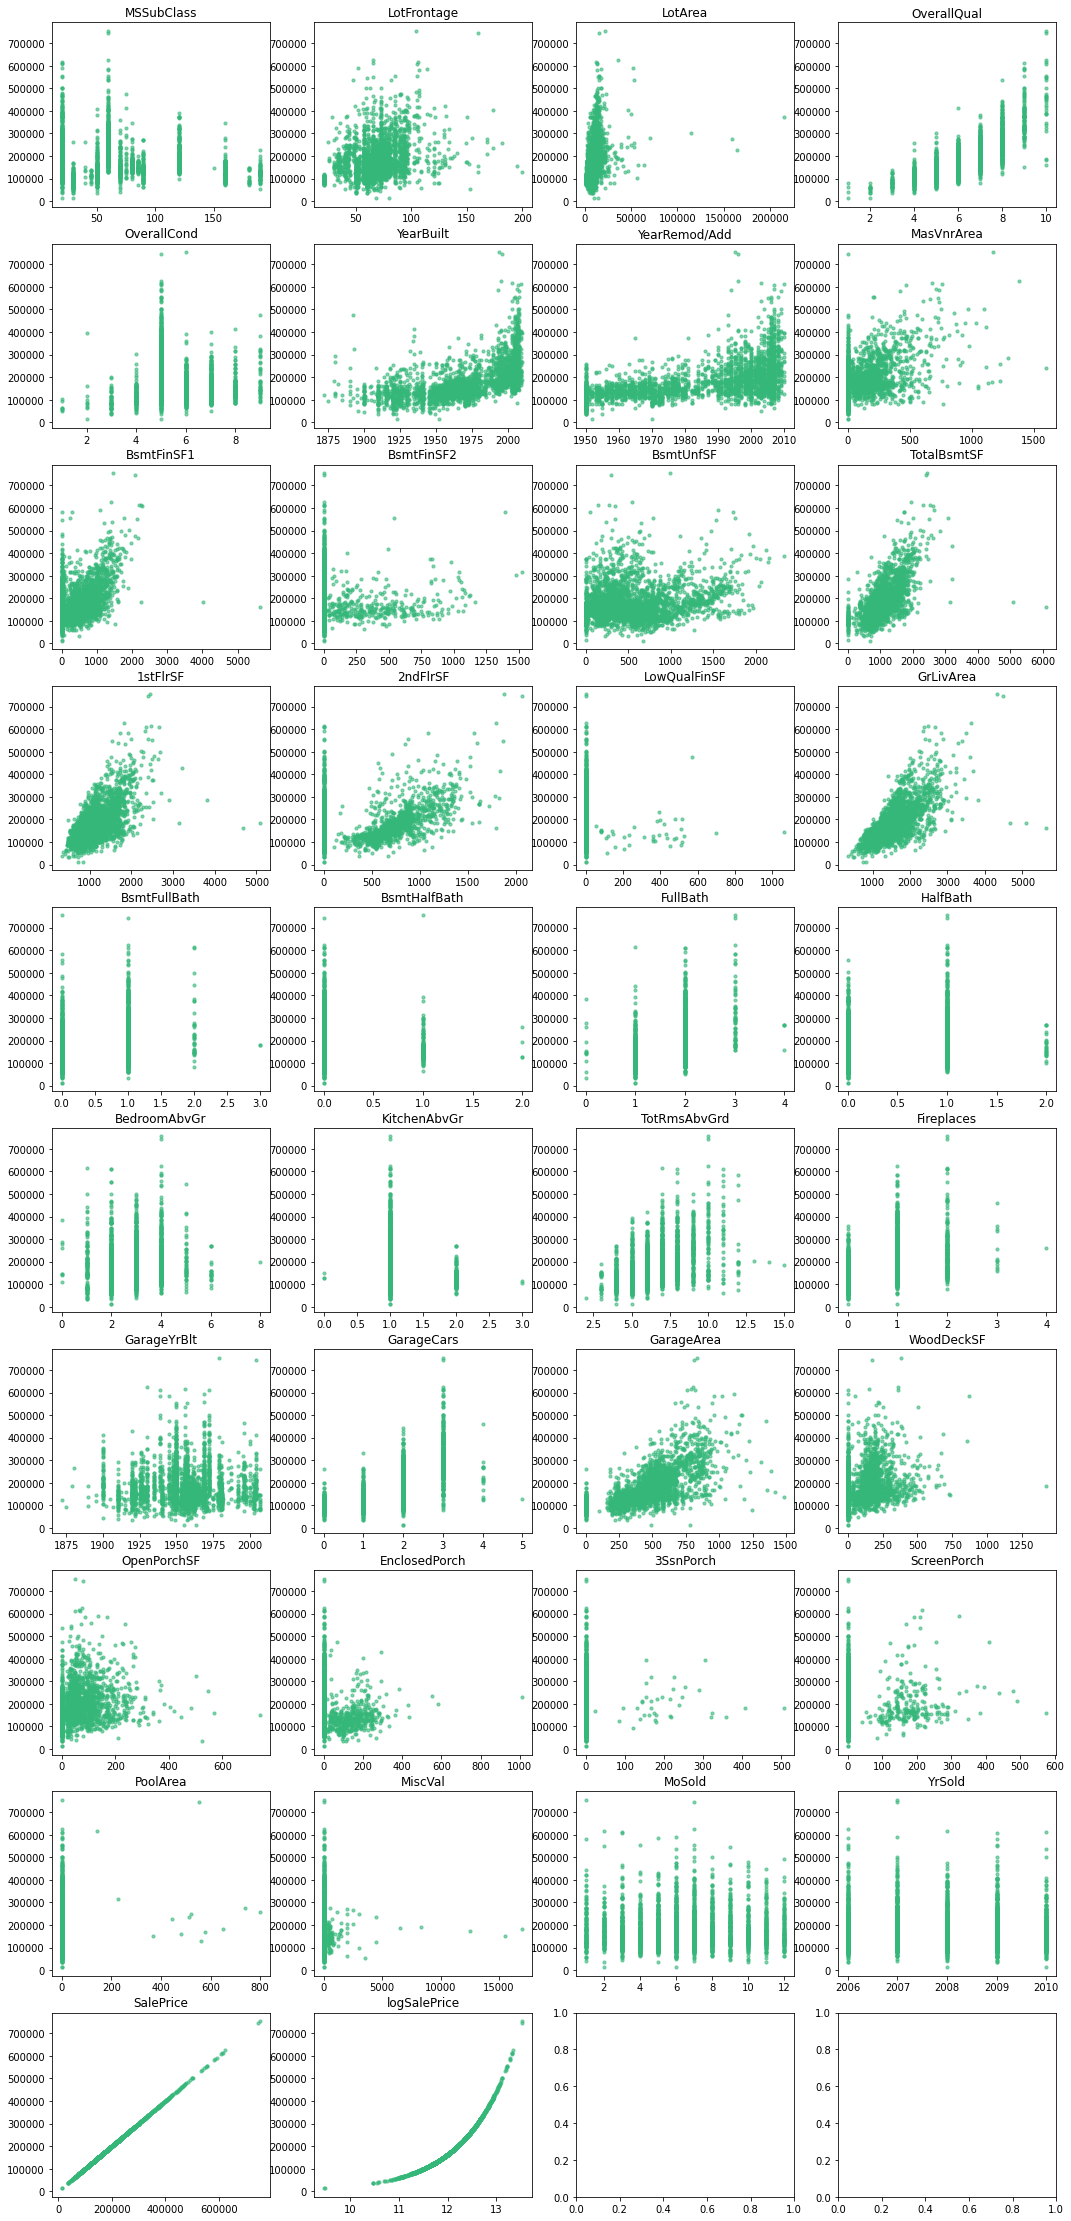

In [18]:
# lets see if there are outliers by plotting our vals

cols = df.select_dtypes(include=np.number).columns[1:]
fig,axes = plt.subplots(nrows=10, ncols=4, figsize=(18, 10*4))

for col, ax in zip(cols, axes.ravel()):
    ax.scatter(df[col], df.SalePrice, alpha=0.6, s=10, color=palette[3])
    ax.set_title(col)

In [19]:
# super visible in lot area and GrLivArea that there are a few values that are outliers
# lets remove them 

df.loc[(df.LotArea > 100_000), ['SalePrice', 'LotArea']] # 4 vals
df.loc[(df.GrLivArea > 4000), ['SalePrice', 'GrLivArea']] # 5 vals
# lets go with GrLivArea, some of the vals are false - 160_000 for the biggest GrLivArea (5642) seems incorrect

df.drop(df.loc[(df.GrLivArea > 4000)].index, inplace=True)

# These were actually not the same as the outliers of LotArea, lets remove them as well
df.drop(df.loc[(df.LotArea > 100_000)].index, inplace=True)

# There are also two house under 20_000 in the sale price, which seems unsual
df.drop(df.loc[(df.SalePrice < 20000)].index, inplace=True)

df.shape # (2919, 81)

(2919, 82)

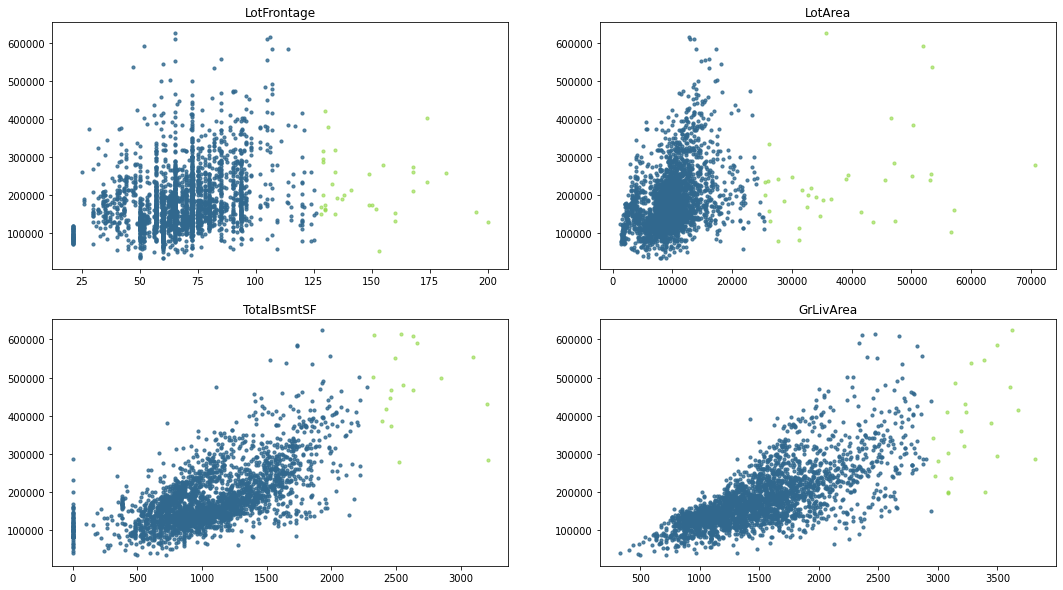

In [20]:
# lets check the usual 3x sttdev and see how many vals we have

cols = ['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea']
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 2*5))

for col, ax in zip(cols, axes.ravel()):
    zscores = (df[col] - df[col].mean()) / (df[col].std())
    x_zscores = np.abs(zscores) > 3
    ax.scatter(df.loc[x_zscores, col], df.loc[x_zscores, 'SalePrice'], alpha=0.6, s=10, color=palette[4])
    ax.scatter(df.loc[~x_zscores, col], df.loc[~x_zscores, 'SalePrice'], alpha=0.8, s=10, color=palette[1])
    ax.set_title(col)

In [21]:
# those from the LotArea feature will ipact the correlation, lets see how many there are
zscores = (df['LotArea'] - df['LotArea'].mean()) / (df['LotArea'].std())
x_zscores = np.abs(zscores) > 3

# 38 of them, lets remove them, I think these will be the only ones as the other variables have good correlation with theirs
df.drop(df.loc[x_zscores].index, inplace=True)

df.shape # (2881, 81)

(2881, 82)

# Feature Engineering

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LinearRegression

cols_to_drop = []
cols_to_use = []
cols_dum = []
cols_ord = []
cols_bool = []

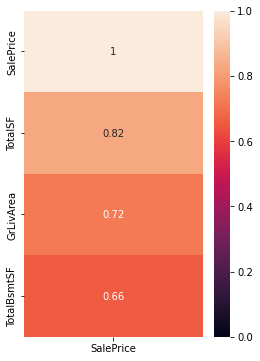

In [23]:
# lets explore one of the main predictor of the price, the SF areas
include_cols = ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'SalePrice']
df[include_cols]

df.loc[(df['LowQualFinSF'] != 0), include_cols].count() # 39 row are not 0!
# Only 39 values are not 0, this column will not be relevant.
# Lets create a list with the cols to drop
cols_to_drop.append('LowQualFinSF')
include_cols.remove('LowQualFinSF')

# BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF
# 1stFlrSF + 2ndFlrSF = GrLivArea
# LotArea sq2 of the proprety (terrain)

correlations = df[include_cols].corr()['SalePrice'] # [df[include_cols].corr()['SalePrice'] >= 0.4]
corr_list = [x for x in correlations.index if x != 'SalePrice']

# TotalBsmtSF/GrLivArea are the best predictors
# Lets create a variable that regroups it with total_SF of the house
df['TotalSF'] = df['TotalBsmtSF'] + df['GrLivArea']

correlations = df[['TotalBsmtSF', 'GrLivArea', 'TotalSF', 'SalePrice']].corr()['SalePrice'] # [df[include_cols].corr()['SalePrice'] >= 0.4]
corr_list = [x for x in correlations.index if x != 'SalePrice']
plt.figure(figsize=(4, 6))
sns.heatmap(correlations.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=0, vmax=1)
plt.show();

We can predict 67.95 % of the SalePrice of a house with only the Total Square Feet that compose it


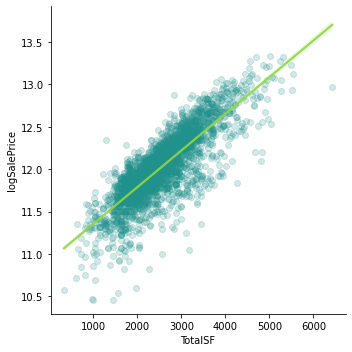

In [24]:
# Lets see as a baseline how much the variable TotalSF can actually predict our price alone
X_TotalSF = df.TotalSF.values.reshape(-1, 1)
y = df.SalePrice

# Create a linear regression object
lr = LinearRegression()
# Fit the model
lr.fit(X_TotalSF, y)
# Compute the R2 cofficient
R2 = lr.score(X_TotalSF, y)

print(f'We can predict {R2 * 100:.2f} % of the SalePrice of a house with only the Total Square Feet that compose it')

#sns.lmplot('TotalSF', 'logSalePrice', df, scatter=True, palette=palette[2]);
sns.lmplot(x='TotalSF', y="logSalePrice",
               data=df, 
               line_kws={'color': palette[4],
                        'alpha': 0.9},
              scatter_kws={'color':palette[2], 
                           'alpha':0.2})
plt.show();

cols_to_use.extend(('TotalSF', 'GrLivArea', 'TotalBsmtSF', 'LotArea')) # lets put everything for now and see if the others than totalSF are relevant in the model
cols_to_drop.extend(('PID', '1stFlrSF', '2ndFlrSF'))

In [25]:
# Lets check all var one by one now to class/remove them

# MSSubClass
df['MSSubClass'] = df['MSSubClass'].astype(str)
cols_dum.append('MSSubClass') # doesnt look super relevant so I could remove it but i'll check the relevance in the model before

# MSZoning
df.MSZoning.value_counts() # MSZoning has 1 industrial and 25 commercial units so I'll remove them
df.drop(df.loc[(df.MSZoning == 'C (all)') | (df.MSZoning == 'I (all)')].index, axis=0, inplace=True) # - 26 obs
cols_dum.append('MSZoning')

# LotFrontage
df[['LotFrontage', 'SalePrice']].corr() # 0.31 corr
cols_to_use.append('LotFrontage')

# Street and Alley are the same --> is there an access to the street, i'll bool it 
cols_to_drop.extend(('Street', 'Alley'))
alley = 'Grvl', 'Pave'
df["HasAlley"] = df['Alley'].replace({'Grvl':1,
                                      'Pave':1,
                                      'NA':0})
cols_bool.append('HasAlley')

# LotShape
df.LotShape = df.LotShape.map({'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4})

cols_ord.append('LotShape')
cols_dum.extend(('LandContour', 'LotConfig', 'LandSlope'))

# Utilities 
cols_to_drop.append('Utilities')

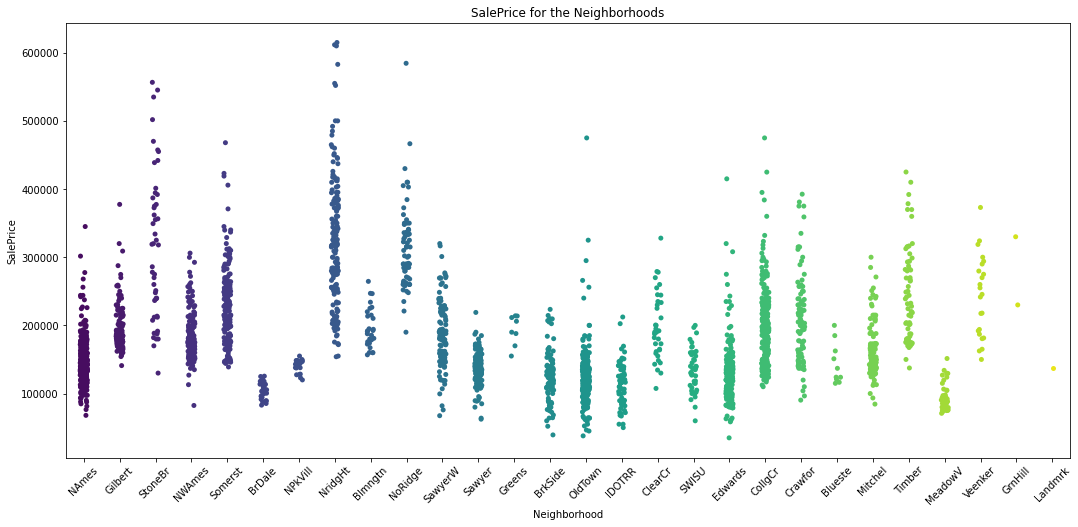

In [26]:
# Neighborhood shoud be relevant, the location of a house I always a good factor --> but there are 18 loc with few vals sometimes, dummify it would be bad here
df.Neighborhood.value_counts() # Some have very few values

# There are no huge difference between neighborhood, but I do think it could be engineer to be elevant
f = plt.figure(figsize=(18,8))
sns.stripplot(x=df.Neighborhood, y=df.SalePrice, palette=sns.color_palette('viridis', df.Neighborhood.unique().shape[0]))
plt.xticks(rotation=45)
plt.title('SalePrice for the Neighborhoods')
plt.show();

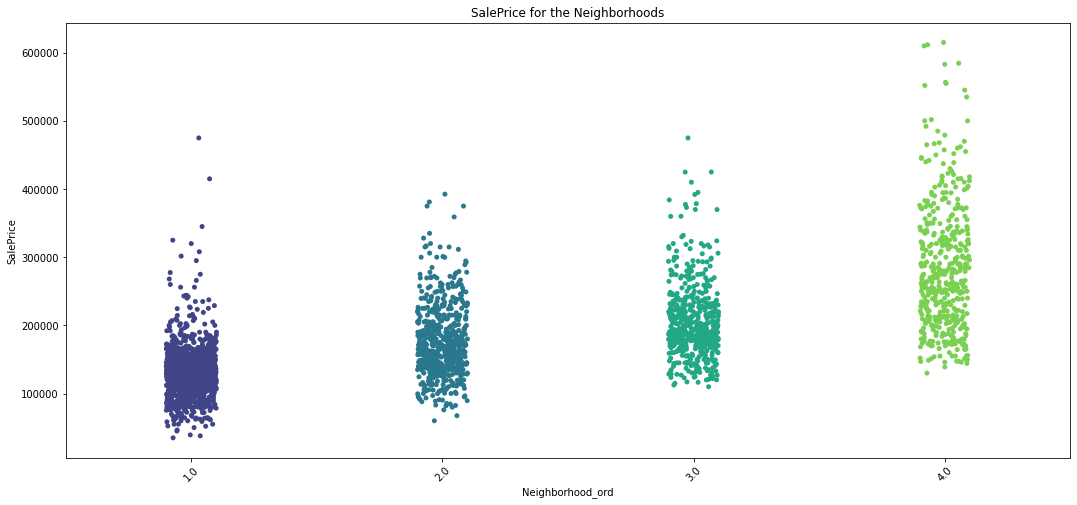

In [27]:
# try to group by OverallQual
grouped = df['OverallQual'].groupby(df.Neighborhood).agg('mean').sort_values()
df['Neighborhood_ord'] = df['Neighborhood'].replace(grouped.to_dict())
df.Neighborhood_ord = df.Neighborhood_ord.astype('float')

# # Lets separate in 4 groups 
# sep = np.linspace(4.378378, 8.367347, 5)
df.loc[(df.Neighborhood_ord < 5.37), 'Neighborhood_ord'] = 1
df.loc[((df.Neighborhood_ord > 5.37) & (df.Neighborhood_ord < 6.37)), 'Neighborhood_ord'] = 2
df.loc[((df.Neighborhood_ord > 6.37) & (df.Neighborhood_ord < 7.37)), 'Neighborhood_ord'] = 3
df.loc[(df.Neighborhood_ord > 7.37), 'Neighborhood_ord'] = 4

# There are no huge difference between neighborhood, but I do think it could be engineer to be elevant
f = plt.figure(figsize=(18,8))
sns.stripplot(x=df.Neighborhood_ord, y=df.SalePrice, palette=sns.color_palette('viridis', df.Neighborhood_ord.unique().shape[0]))
plt.xticks(rotation=45)
plt.title('SalePrice for the Neighborhoods')
plt.show();

cols_dum.append('Neighborhood')
cols_ord.append('Neighborhood_ord')

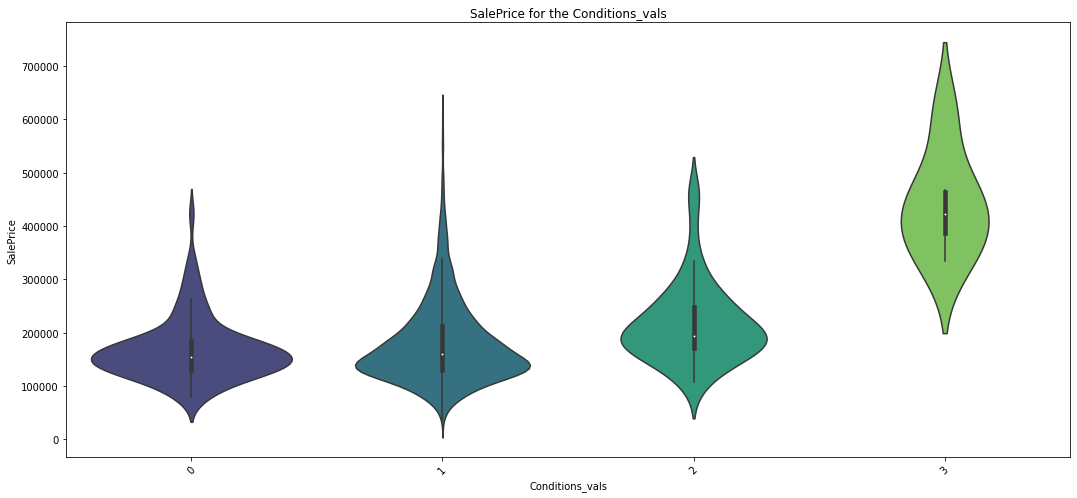

In [28]:
# lets look at Conditions1/2
#https://edlenteam.com/how-location-proximity-affects-your-home-value/

# ++ -> Outdoor Recreation (PosN - PosA)/Starbucks & Dunkin-Shopping (Feedr)
# -- -> Railroad/Artery (Artery - RRNn - RRAn - RRNe - RRAe)

df.Condition1.value_counts()

# adjacent to a postive = +3/ near positive = 2, feedr =1/ norm =0, artery (positive and negative =0)/ near railroad = -1/ adjacent to a railroad = -2

cond_dict = {'PosN':2,'PosA':3,'Feedr':1,'Norm':0,
             'Artery':0, 'RRNn':-1, 'RRAn':-2, 'RRNe':-1, 'RRAe':-2
            }
             
df['Conditions_vals'] = df.Condition1.map(cond_dict) + df.Condition2.map(cond_dict)
# regroup -2/-1 - 0/1 - 2/3 - 4/6
cond_dict = {-2:0,-1:0,
             0:1,1:1,
             2:2,3:2,
             4:3,6:3
            }
df['Conditions_vals'] = df.Conditions_vals.map(cond_dict)
# There are no huge difference between neighborhood, but I do think it could be engineer to be elevant
f = plt.figure(figsize=(18,8))
sns.violinplot(x=df.Conditions_vals, y=df.SalePrice, palette=sns.color_palette('viridis', df.Conditions_vals.unique().shape[0]))
plt.xticks(rotation=45)
plt.title('SalePrice for the Conditions_vals')
plt.show();

cols_dum.extend(('Condition1', 'Condition2')) # CHANGE: before cols drop 
cols_ord.append('Conditions_vals')

In [29]:
# Bldg Type and House Style into dummies

cols_dum.append('BldgType')
cols_dum.append('HouseStyle')

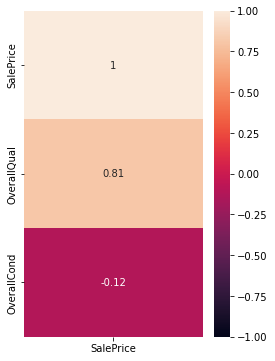

In [30]:
# OverallQual --> super relevant / Overall Cond

corr = df[['OverallQual', 'OverallCond', 'SalePrice']].corr()['SalePrice']
plt.figure(figsize=(4, 6))
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)
plt.show();

cols_ord.append('OverallQual')

# OverallCond Should be relevant but not as ordinal, i'll put it as nominal to see if it has an impac
df['OverallCond'] = df['OverallCond'].astype(str)
cols_dum.append('OverallCond')

there are 1313 houses that have been remodelled


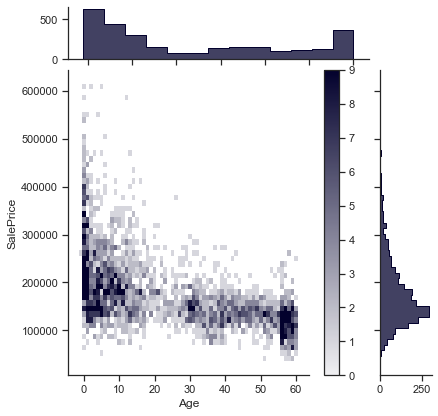

In [31]:
# Year Built (Discrete): Original construction date
# Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
# Garage Yr Blt (Discrete): Year garage was built
# Yr Sold (Discrete): Year Sold (YYYY)
count = 0

for i, row in df[['YearBuilt', 'YearRemod/Add']].iterrows():
    if row[0] != row[1]:
        count += 1
print(f'there are {count} houses that have been remodelled')

df[['YearBuilt', 'YearRemod/Add', 'GarageYrBlt', 'YrSold']]
# lots of vals have their garage built before the house ? Seems weird, I am not going to use that column
cols_to_drop.append('GarageYrBlt')
# I am going to drop the Yearbuilt and create a var age of the house when its sold
cols_to_drop.append('YearBuilt')

df['Age'] = df['YrSold'] - df['YearRemod/Add']

sns.set_theme(style="ticks")

# Load the planets dataset and initialize the figure
planets = sns.load_dataset("planets")
g = sns.JointGrid(data=df, x="Age", y="SalePrice", marginal_ticks=True)

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True)
g.plot_marginals(sns.histplot, element="step", color="#03012d");

# sns.lineplot(df['YearRemod/Add'], df.SalePrice);
# sns.lineplot(df['YrSold'], df.SalePrice); # We can see a drop in the prices from 2007 to 2010 because of the crisis. I am goinf to keep all 3 var

cols_to_use.extend(('YearRemod/Add', 'Age'))

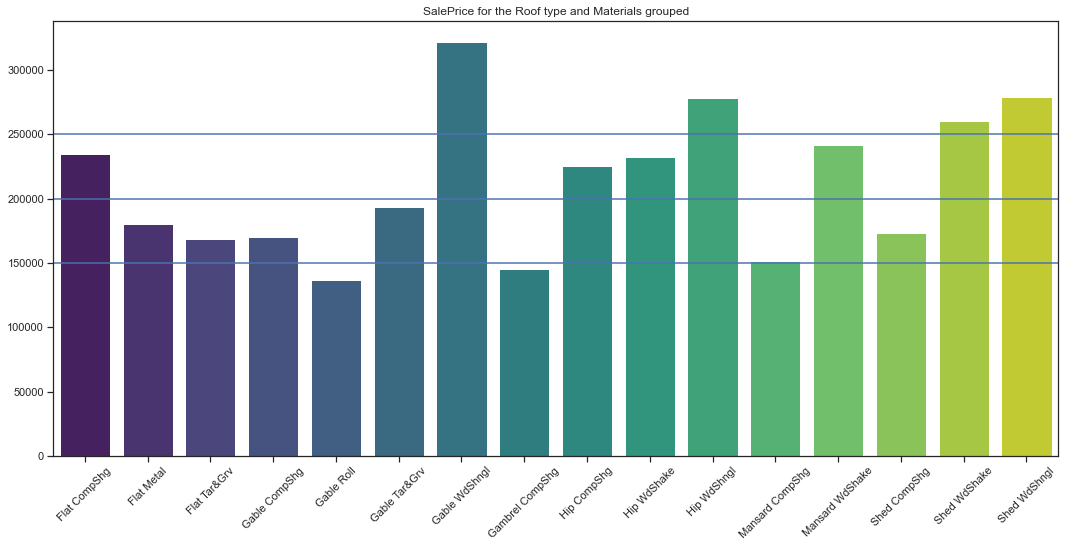

In [32]:
# Roof Style / Roof Matl 

grouped = df[['RoofStyle', 'RoofMatl', 'SalePrice']].groupby(['RoofStyle', 'RoofMatl']).agg('mean') 

new_indx = []
for val in grouped.index.tolist():
    idx = ' '.join(val)
    new_indx.append(idx)

g = plt.figure(figsize=(18,8))
g = sns.barplot(x=new_indx, y=grouped.SalePrice.values, palette=sns.color_palette('viridis', len(new_indx)))

g.axhline(250_000)
g.axhline(200_000)
g.axhline(150_000)

plt.xticks(rotation=45)
plt.title('SalePrice for the Roof type and Materials grouped')
plt.show();

In [33]:
# create an ord scale based on the mean price of those
# 0 < 150_000/ 150_000 < 1 < 200_000/ 200_000 < 2 < 250_000/ 3 > 250_000

df['Roof_ord'] = df['RoofStyle'] + ' ' +  df['RoofMatl']
roof_dict = {'Gable WdShngl':3, 'Hip WdShngl':3, 'Shed WdShake':3, 'Shed WdShngl':3,
             'Flat CompShg':2, 'Hip CompShg':2, 'Hip WdShake':2, 'Mansard WdShake':2,
             'Flat Metal':1, 'Flat Tar&Grv':1, 'Gable CompShg':1, 'Gable Tar&Grv':1, 'Shed CompShg':1,
             'Gable Roll':0, 'Gambrel CompShg':0, 'Mansard CompShg':0}
df['Roof_ord'] = df['Roof_ord'].map(roof_dict)

# cols_to_drop.append('RoofMatl')
cols_dum.extend(('RoofMatl', 'RoofStyle'))
cols_ord.append('Roof_ord')

In [34]:
cols_dum.extend(('Exterior1st', 'Exterior2nd'))

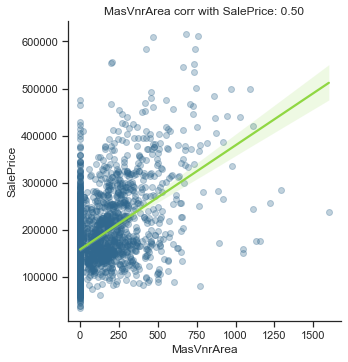

In [35]:
cols_dum.append('MasVnrType')

corr_plot = df[['MasVnrArea', 'SalePrice']].corr()['SalePrice'][0]

sns.lmplot('MasVnrArea', 'SalePrice', 
           data=df, 
           scatter_kws={'alpha':0.3,
                        'color':palette[1]},
           line_kws={'color':palette[4]}
          )
plt.title(f'MasVnrArea corr with SalePrice: {corr_plot:.2f}')
plt.show();

# The var is relevant, lets include it
cols_to_use.append('MasVnrArea')

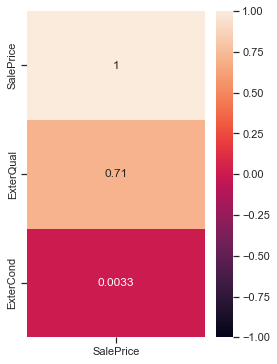

In [36]:
# ExterQual - ExterCond 
# lets watch the correlation with those ordinals var

ord_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
df[['ExterQual','ExterCond']] = df[['ExterQual','ExterCond']].replace(ord_dict)

corr = df[['ExterQual','ExterCond', 'SalePrice']].corr()['SalePrice']
plt.figure(figsize=(4, 6))
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)
plt.show();

# ExterQual is highly correlated with our target but ExterCond brings nothing so lets transform it into nominal
cols_to_use.append('ExterQual')

df['ExterCond'] = df['ExterCond'].astype(str)
cols_dum.append('ExterCond')

In [37]:
# foundation and basement 
cols_dum.append('Foundation')
 
# Replace with ordinal vals
# BsmtQual BsmtCond 
ord_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'NA':0}
df[['BsmtQual','BsmtCond']] = df[['BsmtQual','BsmtCond']].replace(ord_dict)
#BsmtExposure 
ord_dict = {'Gd':5,'Av':4,'Mn':3,'Fa':2,'No':1, 'NA':0}
df['BsmtExposure'] = df['BsmtExposure'].map(ord_dict)
# BsmtFinType1 BsmtFinType2
ord_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2, 'Unf':1, 'NA':0}
df[['BsmtFinType1','BsmtFinType2']] = df[['BsmtFinType1','BsmtFinType2']].replace(ord_dict)

# corr = df[['BsmtFinType1','BsmtFinType2', 'BsmtUnfSF', 'SalePrice']].corr()['SalePrice']
# sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)
                                                                                                    
# BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF --> we are already using TotalBsmt so lets drop the other three
cols_ord.extend(('BsmtFinSF1', 'BsmtUnfSF'))
cols_to_drop.append('BsmtFinSF2')

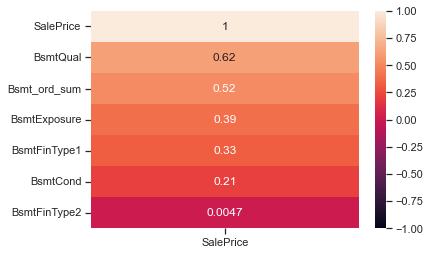

In [38]:
# Lets watch the corr between those variables

# After a few combination to see the relevance I find that this is the most relevant var I can create (taking the val of the bsmt and mult by its expo
df['Bsmt_ord_sum'] = (df['BsmtQual'] * df['BsmtCond']) * df['BsmtExposure']

corr = df[['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'Bsmt_ord_sum','SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

# I will keep those above 0.2
cols_ord.extend(('BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond'))
cols_to_use.append('Bsmt_ord_sum')
cols_to_drop.append('BsmtFinType2')

In [39]:
# Heating - HeatingQC - CentralAir
df.Heating.value_counts()
# almost all GasA, not relevant
cols_to_drop.append('Heating')

ord_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
df.HeatingQC = df.HeatingQC.map(ord_dict)
df[['HeatingQC', 'SalePrice']].corr() # 0.45 --> relevant!
cols_ord.append('HeatingQC')

df.CentralAir = df.CentralAir.map({'Y':1, 'N':0})

cols_bool.append('CentralAir')

In [40]:
# Electrical
df.Electrical.value_counts() # Almost all SBrkr!
cols_to_drop.append('Electrical')

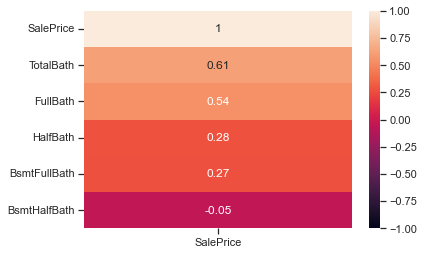

In [41]:
# BsmtFullBath - BsmtHalfBath - FullBath - HalfBath

# Lets do the same as with totalSF and create a total number of Bathrooms
df['TotalBath'] = df[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].sum(axis=1)

corr = df[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath', 'SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

# Super Relevant!
cols_to_use.extend(('TotalBath','BsmtFullBath', 'FullBath', 'HalfBath'))
cols_to_drop.append('BsmtHalfBath')

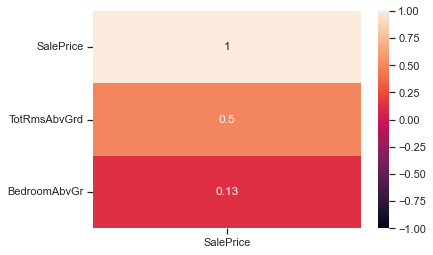

In [42]:
# BedroomAbvGr - TotRmsAbvGrd

corr = df[['BedroomAbvGr', 'TotRmsAbvGrd','SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

cols_to_use.extend(('TotRmsAbvGrd', 'BedroomAbvGr'))
# cols_to_drop.append('BedroomAbvGr')

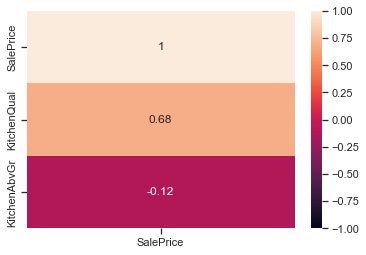

In [43]:
# KitchenAbvGr - KitchenQual

df.KitchenAbvGr.value_counts() # not relevant

ord_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
df.KitchenQual = df.KitchenQual.map(ord_dict)

corr = df[['KitchenQual', 'KitchenAbvGr', 'SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

cols_ord.extend(('KitchenQual', 'KitchenAbvGr')) # super relevant with 0.68
# cols_to_drop.append('KitchenAbvGr')

In [44]:
# Functional
df.Functional.value_counts() # almost all are Typ, lets drop it
cols_dum.append('Functional')

df.Fireplaces.value_counts() # --> to bool
df.Fireplaces = df.Fireplaces.map({0:0,1:1,2:1,3:1,4:1})
cols_bool.append('Fireplaces')
cols_to_drop.append('FireplaceQu')

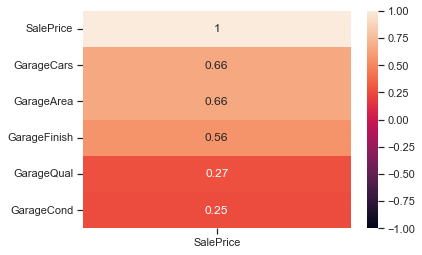

In [45]:
# GarageType - GarageYrBlt - GarageFinish - GarageCars - GarageArea - GarageQual - GarageCond

df.GarageType.value_counts() # dum
cols_dum.append('GarageType')
# GarageYrBlt already used the yrblt of the house -> nop

df.GarageFinish = df.GarageFinish.map({'Fin':3,'RFn':2,'Unf':1,'NA':0})
df[['GarageQual' ,'GarageCond']] = df[['GarageQual' ,'GarageCond']].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'NA':0})

corr = df[['GarageFinish', 'GarageArea', 'GarageCars', 'GarageQual' ,'GarageCond', 'SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

cols_ord.extend(('GarageFinish', 'GarageCond', 'GarageQual'))
cols_to_use.extend(('GarageCars', 'GarageArea'))
cols_to_drop.append('GarageYrBlt')

In [46]:
# Paved Drive
df.PavedDrive.value_counts() # -- not relevant
cols_to_drop.append('PavedDrive')

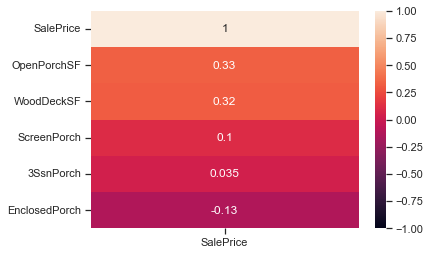

In [47]:
# WoodDeckSF - OpenPorchSF - EnclosedPorch - 3SsnPorch - ScreenPorch

corr= df[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice']].corr()['SalePrice']
sns.heatmap(corr.to_frame().sort_values('SalePrice', ascending=False), annot=True, vmin=-1, vmax=1)

#df[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice']]

df['OpenPorchSF'] = (df['OpenPorchSF'] != 0).astype(int)
#df['WoodDeckSF'] = (df['WoodDeckSF'] != 0).astype(int)
#df['ScreenPorch'] = (df['ScreenPorch'] != 0).astype(int)

cols_to_drop.append('3SsnPorch')
cols_bool.append('OpenPorchSF')
cols_to_use.extend(('WoodDeckSF','EnclosedPorch', 'ScreenPorch'))

In [48]:
# PoolArea - PoolQC --> as bool
# df['PoolArea'] = (df['PoolArea'] != 0).astype(int) --> irrelevant event as bool, 0.04 corr
cols_to_drop.extend(('PoolArea', 'PoolQC'))

In [49]:
# Fence (Ordinal): Fence quality as ord = -0.17 corr/ as bool -0.19
df.Fence = df.Fence.map({'NA':0, 'MnWw':1, 'GdWo':1, 'MnPrv':1, "GdPrv":1})
cols_bool.append('Fence')

In [50]:
# I expect those to be the same as Pool with almost no house having them
df.MiscFeature.value_counts() # almost all NA
df.MiscVal # same

cols_to_drop.extend(('MiscVal', 'MiscFeature'))

In [51]:
# Mo Sold (Discrete): Month Sold (MM)
# Yr Sold (Discrete): Year Sold (YYYY)

df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

cols_dum.extend(('MoSold', 'YrSold'))

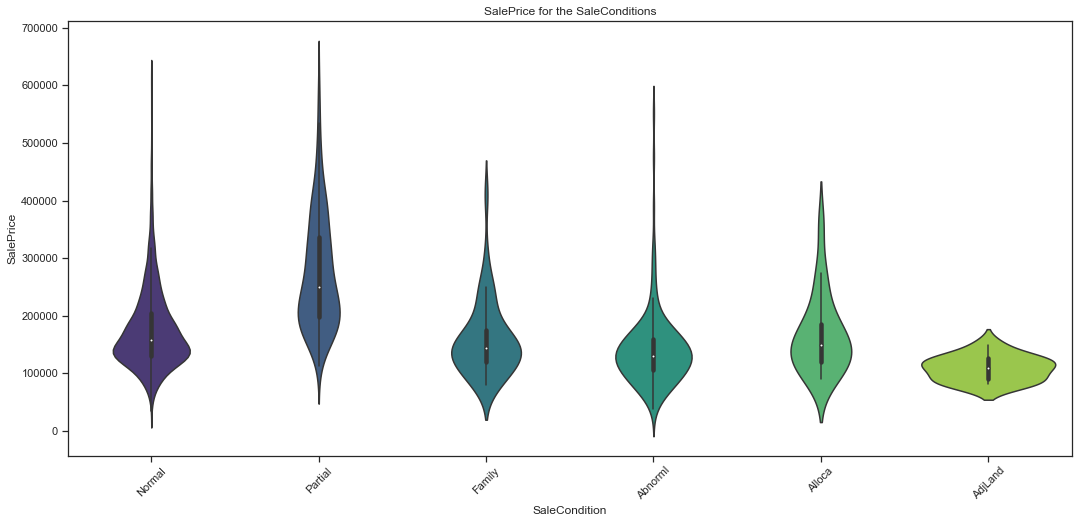

In [52]:
# SaleType - SaleCondition

# both could bring something and dont have too much vals to be dummify
cols_dum.extend(('SaleType', 'SaleCondition'))

f = plt.figure(figsize=(18,8))
sns.violinplot(x=df.SaleCondition, y=df.SalePrice, palette=sns.color_palette('viridis', df.SaleCondition.unique().shape[0]))
plt.xticks(rotation=45)
plt.title('SalePrice for the SaleConditions')
plt.show();

In [53]:
# cols_to_use
# cols_ord
# cols_dum
# cols_bool

df = df.drop(cols_to_drop, axis=1)
count = 0
# check all our wanted cols are there 
for col in df.columns:
    if col not in cols_to_use and col not in cols_ord and col not in cols_dum and col not in cols_bool:
        print(col)
        
# only SalePrice as its the target, perfect!!

SalePrice
logSalePrice


In [54]:
# numeric_feats = df.dtypes[df.dtypes != "object"].index

# # Check the skew of all numerical features
# #skewed_feats = df[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
# skewed_feats = pd.DataFrame(df[numeric_feats].skew(),columns=['skewness'])
# skewed = skewed_feats.loc[skewed_feats.skewness>= 1.0]

# print(f'We have {skewed.shape[0]} feat that are skewed:')
# skewed

# skewed_features = skewed.index.to_list()
# skewed_features.remove('SalePrice')
# lam = 0.15
# for feat in skewed_features:
#     df[feat] = boxcox1p(df[feat], lam)

# Give an actual worst score from 13700 to 14750 MAE

In [55]:
# cols_to_use
# cols_ord
# cols_dum
# cols_bool
target = ['SalePrice']

dict_cols = {'cols_to_use':cols_to_use,
             'cols_ord': cols_ord,
             'cols_dum':cols_dum,
             'cols_bool':cols_bool,
             'target':target}

#create a file
file = open('columns_grouped', 'wb')
#pickle the dataframe
pkl.dump(dict_cols, file)
#close file
file.close()

df.reset_index(drop=True, inplace=True)
df.to_csv("Ames_prepared.csv", encoding = 'utf-8', index=False)